1) Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses relacionadas. Seja criativo!

In [253]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('./desafio_indicium_imdb.csv')

Comecei analisando o dataframe:

In [215]:
df.head()
df.describe()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Aqui, noto algumas coisas que podem atrapalhar a análise. A primeira, é que existe uma coluna extra com o índice dos filmes, que acaba poluindo a matriz de correlação.

In [216]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Outra coisa é que "Gross", a coluna que condiz com o faturamento do filme, é um objeto, e não um número. É plausível pensar que o faturamento de um filme pode ter uma correlação com a sua nota, por isso, decidi convertê-lo em número para poder analisar a correlação mais tarde.

In [217]:
df['Gross'] = df['Gross'].str.replace(',', '').str.strip()
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

Outra coisa que noto, é que, similarmente, o ano de lançamento e a duração do filme são objetos, e não inteiros. Isso pode fazer sentido, já que geralmente não realizamos operações numéricas com essas colunas, mas uma das minhas teorias é a de que filmes mais antigos tendem a ter uma nota maior. Por isso, é importante para mim que essas colunas sejam numéricas.

In [218]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime'] = df['Runtime'].str.replace('min', '').str.strip()
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

Em seguida, o que chama mais atenção é o fato de que algumas células estão vazias. Mais especificamente, 1 célula em Released_Year, 101 células na coluna "Certificate", 157 em "Meta_score" e 169 em "Gross". Decido começar tratando a célula vazia em Released_Year manualmente.

In [219]:
df[df['Released_Year'].isna()]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,NaN,U,140,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.0


Vejo que a célula em que Released_Year é vazio está na linha 965 do dataframe. Pesquisando, encontro que o ano de lançamento do filme em questão (Apollo 13) é 1995.

In [220]:
df.at[965, 'Released_Year'] = 1995

Em seguida, tento checar quantas linhas serão perdidas caso as linhas nulas sejam dropadas.

In [221]:
print(df.shape[0])

dropped_df = df.dropna(subset=['Meta_score', 'Gross'])
dropped_df.shape[0]

999


749

Por enquanto, sigo a análise para depois tentar prever os valores das colunas Gross e Meta_score

Uma das minhas hipóteses é a de que filmes com diretores famosos e renomados tendem a receber uma nota maior no IMDB. Para testar isso, observo a média da nota IMDB de acordo com a quantidade de filmes que os diretores possuem nessa lista.

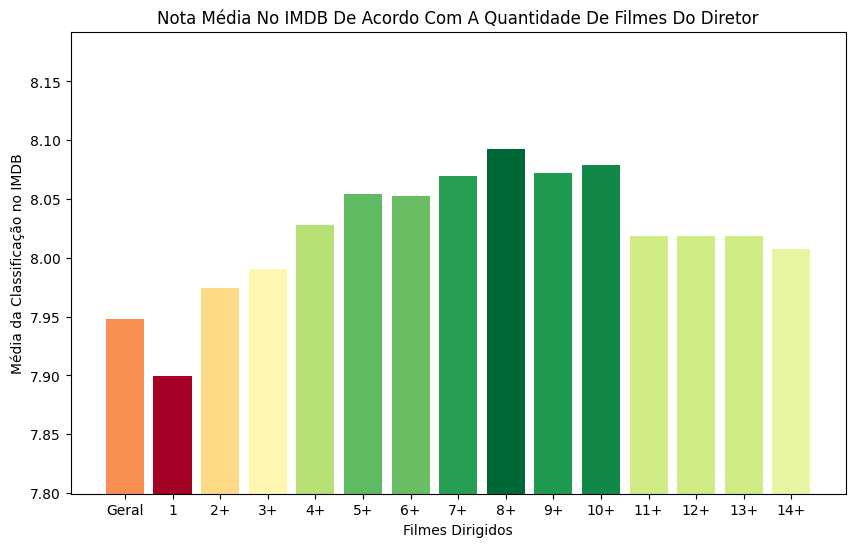

In [222]:
director_ratings = df.groupby('Director')['IMDB_Rating'].mean().reset_index()
director_ratings = director_ratings.sort_values(by='IMDB_Rating', ascending=False)

director_count = df['Director'].value_counts()

# Média do Dataframe
average_ratings = [df['IMDB_Rating'].mean()]
labels = ['Geral']

# Média dos diretores com apenas 1 filme
directors_filter = director_count[director_count == 1 ].index.tolist()
filtered_df = df[df['Director'].isin(directors_filter)]
average_ratings.append(filtered_df["IMDB_Rating"].mean())
labels.append('1')

# Média dos diretores com 2+ filmes
for i in range(2, 15):
    directors_filter = director_count[director_count >= i].index.tolist()
    filtered_df = df[df['Director'].isin(directors_filter)]
    average_ratings.append(filtered_df['IMDB_Rating'].mean())
    labels.append(f'{i}+')


norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Dirigidos')
plt.ylabel('Média da Classificação no IMDB')
plt.title('Nota Média No IMDB De Acordo Com A Quantidade De Filmes Do Diretor')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()

Como podemos ver, os dados sugerem que, embora a relação entre quantidade de filmes dirigidos e média da classificação IMDB não seja estritamente proporcional, há uma tendência de que diretores mais experientes geralmente alcancem uma média de IMDB mais alta do que diretores iniciantes. Portanto, é razoável hipotetizar que filmes dirigidos por diretores com 3+ filmes têm uma probabilidade maior de receber notas melhores no IMDB do que filmes de diretores novatos.

Como o resultado me interessou, decidi conferir se o mesmo era verdade para o Meta_score também.

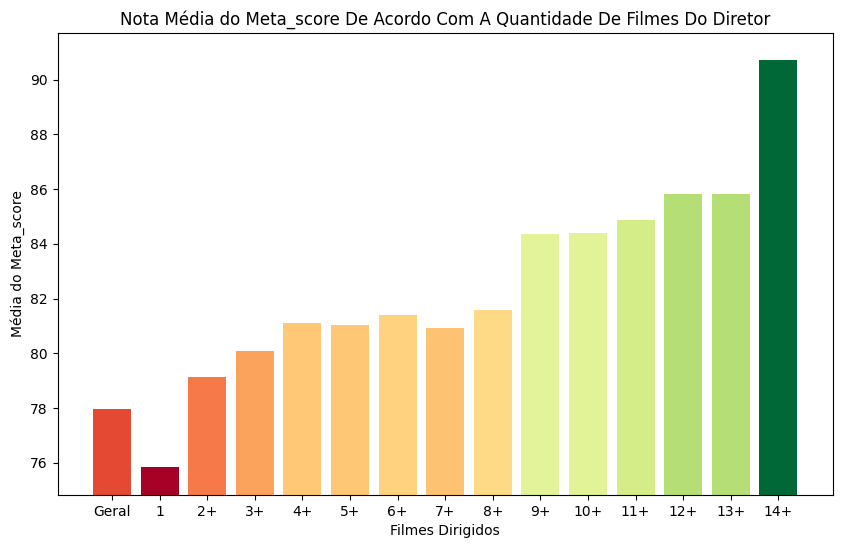

In [223]:
temp_df = df.dropna(subset=['Meta_score'])
director_ratings = temp_df.groupby('Director')['Meta_score'].mean().reset_index()
director_ratings = director_ratings.sort_values(by='Meta_score', ascending=False)

director_count = temp_df['Director'].value_counts()

# Média do Dataframe
average_ratings = [temp_df['Meta_score'].mean()]
labels = ['Geral']

# Média dos diretores com apenas 1 filme
directors_filter = director_count[director_count == 1].index.tolist()
filtered_df = temp_df[temp_df['Director'].isin(directors_filter)]
average_ratings.append(filtered_df["Meta_score"].mean())
labels.append('1')

# Média dos diretores com 2+ filmes
for i in range(2, 15):
    directors_filter = director_count[director_count >= i].index.tolist()
    filtered_df = temp_df[temp_df['Director'].isin(directors_filter)]
    average_ratings.append(filtered_df['Meta_score'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Dirigidos')
plt.ylabel('Média do Meta_score')
plt.title('Nota Média do Meta_score De Acordo Com A Quantidade De Filmes Do Diretor')
plt.ylim(min(average_ratings) - 1, max(average_ratings) + 1)

plt.show()


O resultado dessa vez foi surpreendente. É possível ver que o crescimento do Meta Score de acordo com a quantidade de filmes de um diretor é consideravelmente mais acentuado do que o do IMDB Rating.

Levando o resultado dessas análises em consideração, decidi que valia a pena adicionar uma coluna no dataframe que levasse em consideração a experiência do diretor de cada filme, contasse quantos filmes aquele diretor havia feito, pois seria uma variável relevante na matriz de correlação. Além disso, optei por uma outra abordagem alternativa: Adicionar também ma coluna binária que diz se um diretor participou de 3 ou mais filmes.

In [224]:
df['No_of_Directed_Movies'] = df['Director'].map(df['Director'].value_counts())
df['Experienced_Director'] = (df['No_of_Directed_Movies'] >= 3).astype(int)

Em seguida, achei interessante fazer a mesma análise para os atores. Isto é, verificar se atores famosos também influenciavam na classificação de um filme. Para isso, decidi começar checando se haviam erros a serem tratados. Primeiro, decidi checar se um ator pode aparecer múltiplas vezes na mesma linha. Depois, chequei se um ator pode aparecer em colunas diferentes, por exemplo, se ele pode aparecer como Star1 em um filme e Star2 em outro.

In [225]:
# Criando um DataFrame separado para os testes
actor_df = pd.DataFrame(df)

# Checando se o Star1 aparece repetidas vezes na mesma linha
same_line_mask = actor_df.apply(lambda row: row['Star1'] in (row['Star2'], row['Star3'], row['Star4']), axis=1)
print(len(actor_df[same_line_mask]))



# Checando se o Star1 aparece em colunas diferentes em outros filmes
other_columns = pd.concat([df['Star2'], df['Star3'], df['Star4']])
actor_df['Star1_duplicate'] = actor_df['Star1'].apply(lambda x: x in other_columns.values)

print(len(actor_df[actor_df['Star1_duplicate']]))

4
508


Após perceber que haviam alguns pontos a serem corrigidos, decidi tratar essas colunas, separar a quantidade de filmes que cada ator havia feito, e realizar a mesma análise em relação ao IMDB Rating e Meta_score.

Comecei criando um novo dataframe, com uma coluna para a contagem de quantos filmes cada ator participou. Tomei os cuidados de considerar o mesmo ator em colunas diferentes e de não contar um ator mais de uma vez na mesma linha.

Em seguida, usei o dataframe original para calcular a média do IMDB em que cada ator participou e calculei a média das classificações de acordo com o número de filmes dos atores.

Finalmente, repeti os mesmos passos para o Meta_score, porém com o cuidado extra de dropar as linhas em que o Meta_score não aparecia.

C:\Users\guilh\AppData\Local\Temp\ipykernel_3432\3870228453.py:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['Star'] = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda x: pd.unique(x.dropna().tolist()), axis=1)


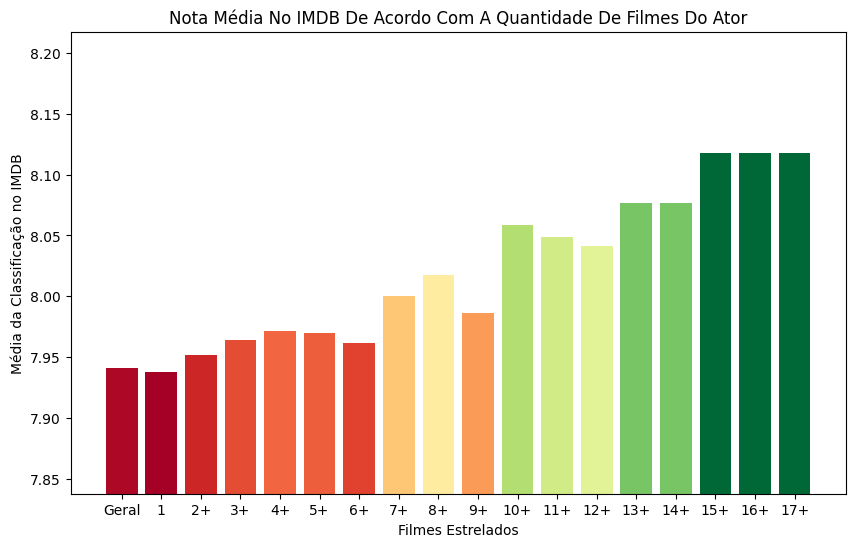

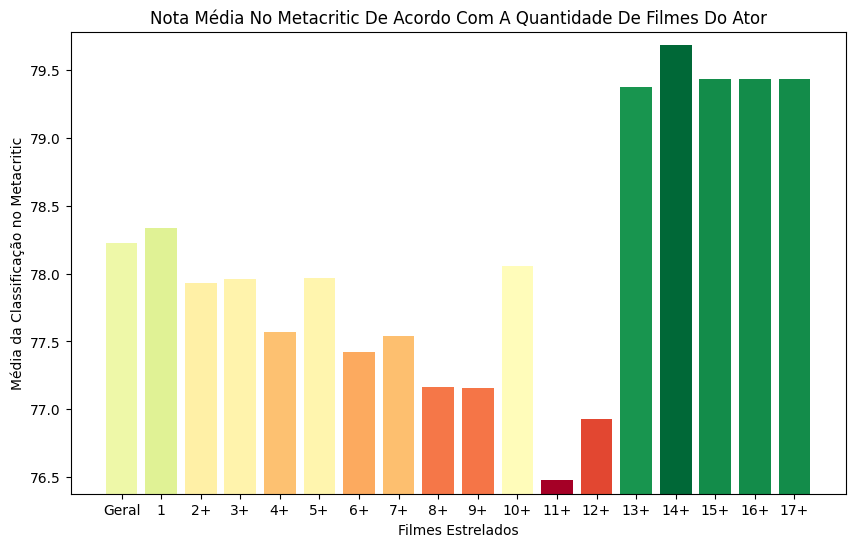

In [226]:
all_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])

# Certificando que um ator não aparecerá duplicado na mesma linha
actors_per_movie = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda row: set(row), axis=1)

# Certificando que os atores são contados independentemente da coluna em que apareçam 
all_stars_unique = pd.Series([actor for actors in actors_per_movie for actor in actors])
star_counts = all_stars_unique.value_counts()

star_df = pd.DataFrame({
    'Star': star_counts.index,
    'No_of_Movies': star_counts.values
})

# Capturando o IMDB médio de cada ator
df['Star'] = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda x: pd.unique(x.dropna().tolist()), axis=1)
exploded_df = df.explode('Star')
imdb_ratings = exploded_df.groupby('Star')['IMDB_Rating'].mean().reset_index()

star_df = pd.merge(star_df, imdb_ratings, on='Star')
star_df.rename(columns={'IMDB_Rating': 'Average_IMDB_Rating'}, inplace=True)

# Plotando
# Média do Dataframe
average_ratings = [star_df['Average_IMDB_Rating'].mean()]
labels = ['Geral']

# Média dos atores com apenas 1 filme
average_ratings.append(star_df[star_df['No_of_Movies'] == 1]['Average_IMDB_Rating'].mean())
labels.append('1')

# Média dos atores com 2+ filmes
for i in range(2, 18):
    average_ratings.append(star_df[star_df['No_of_Movies'] >= i]['Average_IMDB_Rating'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Estrelados')
plt.ylabel('Média da Classificação no IMDB')
plt.title('Nota Média No IMDB De Acordo Com A Quantidade De Filmes Do Ator')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()

# Capturando o Meta médio de cada ator
exploded_df = exploded_df.dropna(subset=['Meta_score'])
meta_ratings = exploded_df.groupby('Star')['Meta_score'].mean().reset_index()

star_df = pd.merge(star_df, meta_ratings, on='Star')
star_df.rename(columns={'Meta_score': 'Average_Meta_score'}, inplace=True)

# Plotando
# Média do Dataframe
average_ratings = [star_df['Average_Meta_score'].mean()]
labels = ['Geral']

# Média dos atores com apenas 1 filme
average_ratings.append(star_df[star_df['No_of_Movies'] == 1]['Average_Meta_score'].mean())
labels.append('1')

# Média dos atores com 2+ filmes
for i in range(2, 18):
    average_ratings.append(star_df[star_df['No_of_Movies'] >= i]['Average_Meta_score'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Estrelados')
plt.ylabel('Média da Classificação no Metacritic')
plt.title('Nota Média No Metacritic De Acordo Com A Quantidade De Filmes Do Ator')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()


A análise acima implica que filmes com atores conhecidos costumam ir melhor tanto com o público quanto com a crítica, e por isso, achei interessante levar esse número em consideração na matriz de correlação. 

Como existem 4 colunas com atores no dataframe, pensei em uma maneira criativa de responder as seguintes perguntas: 

1 - O quão famosos são os atores estrelando o filme como um todo?

Para responder essa, decidi por utilizar uma média simples da quantidade de filmes estrelados de todos os atores de cada filme.

2 - Algum ator muito famoso estrelou o filme?

Para responder essa, criei uma coluna que tem o valor 1, caso qualquer ator no filme tenha estreado em 5 ou mais filmes.

In [227]:
star_df = star_df.reset_index()

def calculate_average_fame(row):
    stars = [row['Star1'], row['Star2'], row['Star3'], row['Star4']]
    total_movies = star_df[star_df['Star'].isin(stars)]['No_of_Movies'].sum()
    average_fame = total_movies / 4
    return average_fame

def famous_star(row):
    stars = [row['Star1'], row['Star2'], row['Star3'], row['Star4']]
    movie_counts = star_df[star_df['Star'].isin(stars)]['No_of_Movies']
    return 1 if (movie_counts >= 5).any() else 0


df['Average_Fame'] = df.apply(calculate_average_fame, axis=1)
df['Famous_Star'] = df.apply(famous_star, axis=1)


Por fim, aproveitei para observar quais eram os gêneros favoritos do público e da crítica

In [228]:
public_genre = df.groupby('Genre')['IMDB_Rating'].mean().reset_index()

public_genre.columns = ['Genre', 'Average_IMDB_Rating']

sorted_genres = public_genre.sort_values(by='Average_IMDB_Rating', ascending=False)

top_20_genres = sorted_genres.head(20)

print(top_20_genres)

                            Genre  Average_IMDB_Rating
80          Animation, Drama, War             8.500000
34                 Action, Sci-Fi             8.400000
166                Drama, Musical             8.400000
171           Drama, Mystery, War             8.350000
201                       Western             8.350000
144        Drama, Fantasy, Horror             8.300000
116      Comedy, Musical, Romance             8.300000
127           Crime, Drama, Music             8.300000
131          Crime, Drama, Sci-Fi             8.300000
59   Adventure, Mystery, Thriller             8.300000
197    Mystery, Romance, Thriller             8.300000
141          Drama, Family, Sport             8.250000
138                 Drama, Family             8.233333
6      Action, Adventure, Fantasy             8.200000
148           Drama, Fantasy, War             8.200000
29           Action, Drama, Sport             8.200000
143       Drama, Fantasy, History             8.200000
115       

In [229]:
critic_genre = df.groupby('Genre')['Meta_score'].mean().reset_index()

critic_genre.columns = ['Genre', 'Average_Meta_score']

sorted_genres = critic_genre.sort_values(by='Average_Meta_score', ascending=False)

top_20_genres = sorted_genres.head(20)

print(top_20_genres)

                            Genre  Average_Meta_score
151     Drama, Film-Noir, Romance               100.0
197    Mystery, Romance, Thriller               100.0
116      Comedy, Musical, Romance                99.0
59   Adventure, Mystery, Thriller                98.0
115        Comedy, Music, Romance                98.0
148           Drama, Fantasy, War                98.0
155       Drama, History, Romance                97.0
10     Action, Adventure, Romance                97.0
190  Film-Noir, Mystery, Thriller                97.0
114        Comedy, Music, Musical                96.0
152                Drama, History                96.0
189            Film-Noir, Mystery                96.0
124       Crime, Drama, Film-Noir                96.0
191           Film-Noir, Thriller                94.0
80          Animation, Drama, War                94.0
117          Comedy, Musical, War                93.0
113                 Comedy, Music                92.0
74       Animation, Comedy, 

Para encontrar uma maneira de preencher as linhas de "Gross" e "Meta_score", é necessário entender se existe alguma correlação entre essas colunas e as outras. Para isso, optei por remover as linhas em que elas estão vazias para ter uma melhor dimensão de como poderia preenchê-las

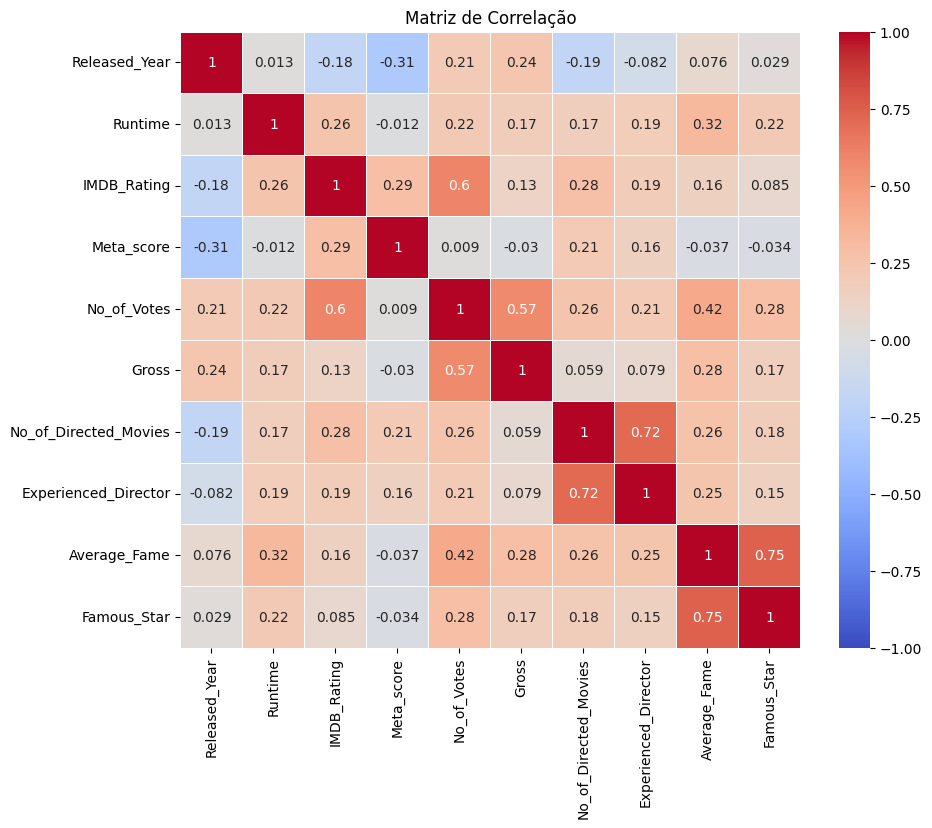

In [230]:
df_cleaned = df.dropna(subset=['Meta_score', 'Gross'])
df_numeric = df_cleaned.select_dtypes(include='number')

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

No momento, existem 2 variáveis numéricas de interesse imediato: Meta_score e Gross, pois precisam ser preenchidos

Da matriz acima, podemos tirar as seguintes conclusões:

1 - Meta_score possui uma correlação **POSITIVA FRACA** com No_of_Directed_Movies, **POSITIVA FRACA** com Experienced_Director, **POSITIVA MODERADA** com IMDB_Rating e **NEGATIVA MODERADA** com Released_Year,  o que mostra que filmes bem recebidos pelo público tendem a ser bem recebidos pela crítica e comprova as teorias de que filmes mais antigos e dirigidos por diretores experientes são melhor avaliados.

2 - Gross possui uma correlação **POSITIVA FRACA** com Released_Year, Runtime, Famous_Star e IMDB_Rating, **POSITIVA MODERADA** com Average_Fame e **POSITIVA FORTE** com o No_of_Votes, o que indica que filmes mais recentes, mais longos e estrelados por atores mais experientes arrecadam mais dinheiro e costumam receber consideravelmente mais votos. Numa análise mais profunda, esses fatores sugerem que o cinema como um todo tem se tornado mais popular e mais lucrativo com o tempo.

2) Responda também às seguintes perguntas: <br>
a) Qual filme você recomendaria para uma pessoa que você não conhece?


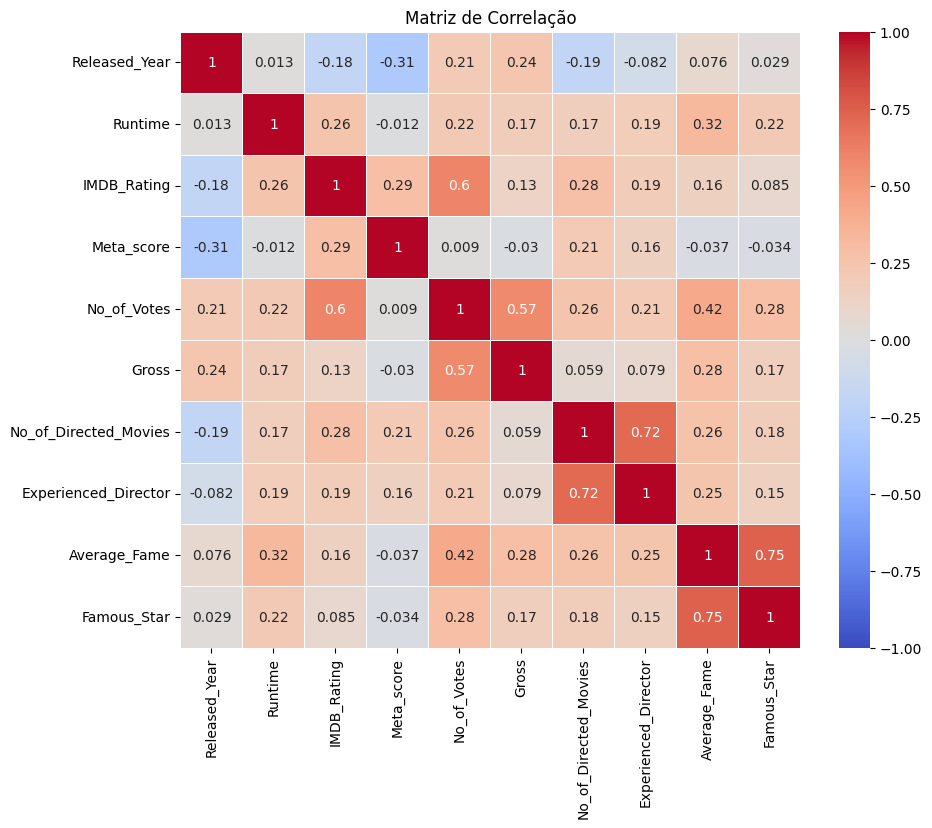

In [231]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Tendo em vista a matriz de correlação acima, o principal fator para determinar o gosto do público pelo filme é o No_of_Votes, por isso, decido começar olhando os filmes mais votados.

In [232]:
top_voted_movies = df.sort_values(by='No_of_Votes', ascending=False)

top_20_movies = top_voted_movies.head(20)

print(top_20_movies[['Series_Title', 'Genre', 'IMDB_Rating']])

                                          Series_Title  \
1                                      The Dark Knight   
7                                            Inception   
8                                           Fight Club   
5                                         Pulp Fiction   
10                                        Forrest Gump   
13                                          The Matrix   
9    The Lord of the Rings: The Fellowship of the Ring   
4        The Lord of the Rings: The Return of the King   
0                                        The Godfather   
62                               The Dark Knight Rises   
20                                        Interstellar   
12               The Lord of the Rings: The Two Towers   
26                                               Se7en   
61                                    Django Unchained   
38                                           Gladiator   
154                                      Batman Begins   
27            

Olhando novamente para os gêneros mais aclamados pelo público, podemos ver que quase muitos desses filmes possuem os gêneros: Drama, Romance, Ação, Comédia e Guerra

In [233]:
public_genre = df.groupby('Genre')['IMDB_Rating'].mean().reset_index()

public_genre.columns = ['Genre', 'Average_IMDB_Rating']

sorted_genres = public_genre.sort_values(by='Average_IMDB_Rating', ascending=False)

top_20_genres = sorted_genres.head(20)

print(top_20_genres)

                            Genre  Average_IMDB_Rating
80          Animation, Drama, War             8.500000
34                 Action, Sci-Fi             8.400000
166                Drama, Musical             8.400000
171           Drama, Mystery, War             8.350000
201                       Western             8.350000
144        Drama, Fantasy, Horror             8.300000
116      Comedy, Musical, Romance             8.300000
127           Crime, Drama, Music             8.300000
131          Crime, Drama, Sci-Fi             8.300000
59   Adventure, Mystery, Thriller             8.300000
197    Mystery, Romance, Thriller             8.300000
141          Drama, Family, Sport             8.250000
138                 Drama, Family             8.233333
6      Action, Adventure, Fantasy             8.200000
148           Drama, Fantasy, War             8.200000
29           Action, Drama, Sport             8.200000
143       Drama, Fantasy, History             8.200000
115       

Por isso, eu recomendaria filmes que tenham ao menos 2 desses marcadores. Os 3 filmes com o maior número de votos e que possuem pelo menos 2 dos marcadores são:

- The Dark Knight
- Forrest Gump
- The Lord of the Rings: The Fellowship of the Ring

Por isso, esses seriam os filmes que eu recomendaria a alguém que não conheço.

b) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

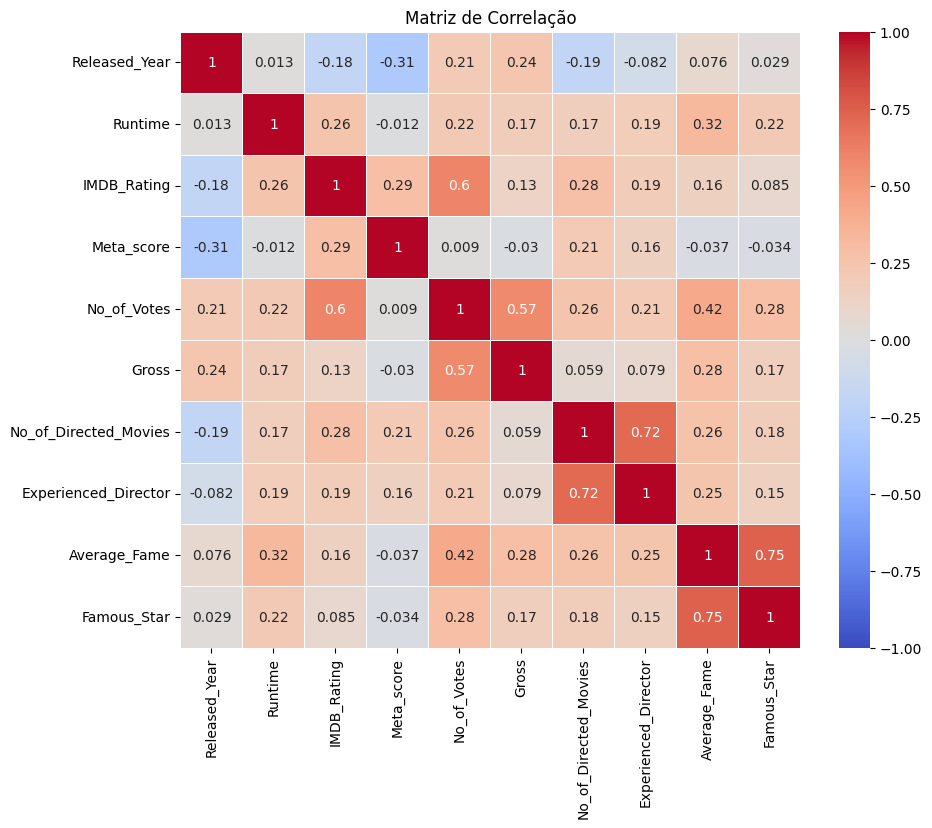

In [234]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Seguindo novamente a matriz de correlação, os principais fatores relacionados com o sucesso de bilheteria de um filme são:

1) No_of_Votes - Se um filme fatura bem, receberá muitas reviews.

2) Average_Fame - Um filme estrelado por atores conhecidos costuma ir melhor nas bilheterias.

3) Released_Year - Filmes mais recentes costumam ter faturamento maior. Minha hipótese é que isso tenha a ver com a popularização do cinema com o tempo.

4) Runtime - Filmes mais longos costumam faturar mais.

Em conclusão:

Dois fatores importantes para prever o faturamento de um filme ANTES de seu lançamento são a fama prévia de seu elenco e sua duração.

Dois fatores que podem ajudar a prever o faturamente de um filme APÓS seu lançamento são o número de reviews que ele recebeu e o ano em que foi lançado.

PS.: Mais tarde, ao transformar os valores categóricos em números, notei que a classificação indicativa do filme também é relevante para o seu faturamento.

c) Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Meu primeiro passo foi tentar uma Regressão Logística

In [235]:
df['Overview'] = df['Overview'].str.lower().str.replace('[^\w\s]', '')

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Overview'])
Y = df['Genre']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

                              precision    recall  f1-score   support

Action, Adventure, Biography       0.00      0.00      0.00         1
   Action, Adventure, Comedy       0.00      0.00      0.00         1
    Action, Adventure, Drama       0.00      0.00      0.00         1
  Action, Adventure, Fantasy       0.00      0.00      0.00         2
   Action, Adventure, Horror       0.00      0.00      0.00         1
  Action, Adventure, Mystery       0.00      0.00      0.00         1
   Action, Adventure, Sci-Fi       0.00      0.00      0.00         3
  Action, Adventure, Western       0.00      0.00      0.00         1
    Action, Biography, Crime       0.00      0.00      0.00         1
    Action, Biography, Drama       0.00      0.00      0.00         2
       Action, Comedy, Crime       0.00      0.00      0.00         1
     Action, Comedy, Fantasy       0.00      0.00      0.00         1
        Action, Crime, Drama       0.00      0.00      0.00         9
      Action, Drama

c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Logo percebi que os múltiplos gêneros estavam atrapalhando a análise, pois cada filme tinha um gênero muito específico, composto de vários outros. Para facilitar a análise, decidi pegar somente a primeira palavra de cada gênero e tentar novamente.

In [236]:
def get_first_genre(genre_str):
    return genre_str.split(',')[0].strip()

df['First_Genre'] = df['Genre'].apply(get_first_genre)

df['Overview'] = df['Overview'].str.lower().str.replace('[^\w\s]', '')

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Overview'])
Y = df['First_Genre']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Precisão: ", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Precisão:  0.335
              precision    recall  f1-score   support

      Action       0.33      0.13      0.19        31
   Adventure       0.00      0.00      0.00        15
   Animation       0.00      0.00      0.00        18
   Biography       0.00      0.00      0.00        18
      Comedy       0.50      0.04      0.07        28
       Crime       1.00      0.04      0.08        23
       Drama       0.33      0.98      0.49        62
      Horror       0.00      0.00      0.00         3
     Mystery       0.00      0.00      0.00         2

    accuracy                           0.34       200
   macro avg       0.24      0.13      0.09       200
weighted avg       0.34      0.34      0.20       200



c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

A precisão do modelo não é muito alta, por isso, fiz mais uma tentativa, dessa vez tratando Genre como um array de gêneros.

In [237]:

def parse_genres(genre_str):
    return [genre.strip() for genre in genre_str.split(',')]

df['Genre_List'] = df['Genre'].apply(parse_genres)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Overview'])

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['Genre_List'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = OneVsRestClassifier(LogisticRegression())

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print("Precisão: ", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


Precisão:  0.105
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        34
   Adventure       0.00      0.00      0.00        40
   Animation       0.00      0.00      0.00        18
   Biography       0.00      0.00      0.00        25
      Comedy       0.00      0.00      0.00        46
       Crime       0.00      0.00      0.00        43
       Drama       0.79      1.00      0.88       157
      Family       0.00      0.00      0.00         5
     Fantasy       0.00      0.00      0.00         9
   Film-Noir       0.00      0.00      0.00         3
     History       0.00      0.00      0.00         8
      Horror       0.00      0.00      0.00        10
       Music       0.00      0.00      0.00         9
     Musical       0.00      0.00      0.00         4
     Mystery       0.00      0.00      0.00        23
     Romance       0.00      0.00      0.00        21
      Sci-Fi       0.00      0.00      0.00        11
       Spo

c:\Users\guilh\Desktop\codes\Lighhouse-Ciencia-de-Dados\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Nesse caso, a precisão foi ainda menor. O modelo parece estar sofrendo com a quantidade baixa de amostras.

3) Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

A primeira resposta é que estamos lidando com um problema de regressão, já que estamos prevendo valores contínuos. Um problema de classificação tenta prever valores categóricos.

Primeiramente, para analisar o IMDB_Rating, eu tentaria transformar as colunas categóricas em números.

In [238]:
cat_cols=['Certificate', 'Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'First_Genre']
le =LabelEncoder()

for i in cat_cols:
    df[i]=le.fit_transform(df[i])

Em seguida, faço novamente a matriz de correlação para analisar possíveis novas correlações.

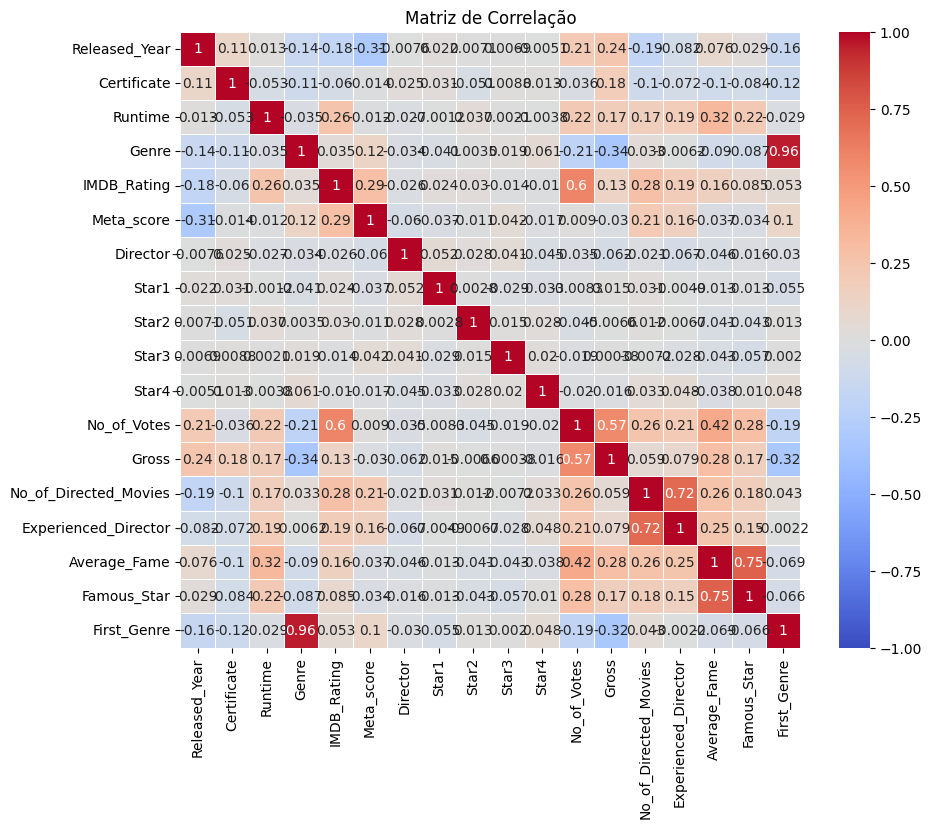

In [239]:
df_cleaned = df.dropna(subset=['Meta_score', 'Gross'])
df_numeric = df_cleaned.select_dtypes(include='number')

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Nessa matriz, observo que os fatores mais relevantes para a análise são o Runtime, Meta_score e No_of_Votes. Por isso, tendo em vista que o DF possui muitas colunas, removeria algumas que não julgo tão relevantes para essa análise, juntamente com os itens nulos, deixando apenas as mais importantes.

In [240]:
df = df.dropna()
df = df.drop(columns=['Series_Title', 'Released_Year','Certificate', 'Genre', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Gross', 'Experienced_Director', 'Star', 'Average_Fame', 'Famous_Star', 'First_Genre', 'Genre_List', 'No_of_Directed_Movies'])

Comecei tratando os dados e separando-os em sets de teste e treino.

In [241]:
skewed_features = ['Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes']

for i in skewed_features:
    df[i]=np.log(df[i]+1)
    
X = df.drop(labels=['IMDB_Rating'], axis=1)
Y = df['IMDB_Rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=40)


Após testar alguns modelos, como RidgeRegression, RandomForestRegressor e DecisionTreeRegressor, decidi usar uma LinearRegression comum, O RMSE médio da validação cruzada foi escolhido como medida de performance, já que se aproxima muito de 0.

In [248]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
cv_scores = cross_val_score(lm, X, Y, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()
print(f"RMSE Médio de Validação Cruzada: {np.sqrt(mean_cv_score)}")

RMSE Médio de Validação Cruzada: 0.035528007718172584


O principal pró de utilizar a LinearRegression ao invés dos outros modelos citados é o menor risco de overfitting, levando em conta que o dataframe é bem pequeno, e acaba ficando difícil generalizar com outros modelos.

O principal contra é justamente o quanto o modelo é sensível, principalmente a dados atípicos (outliers) e a dataframes com poucas informações. Para mitigar isso, tentei deixar o dataframe o mais reduzido e objetivo o possível.

4) Supondo um filme com as seguintes características:

```{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?

Utilizando o modelo criado antes, tento prever a nota do filme.

In [249]:
shawshank = {
 'Runtime': 142,
 'Meta_score': 80.0,
 'No_of_Votes': 2343110,
}

shawshank_df = pd.DataFrame([shawshank])

for feature in ['Runtime', 'Meta_score', 'No_of_Votes']:
    shawshank_df[feature] = np.log(shawshank_df[feature] + 1)


predicted_rating = lm.predict(shawshank_df)

print(predicted_rating[0])

Acabou longe da realidade, mas realmente me esforcei muito nesse modelo! Nessa semana tive uma cirurgia de remoção de sisos, e vim programar mesmo sob efeito de anestesia e ainda por cima passei meu aniversário (a última sexta-feira) codando esse programa. Tenho muita vontade de aprender e espero muito conseguir uma oportunidade. Gostaria muito de aprender mais. Apesar de todos os desafios, estou orgulhoso de ter tentado e finalizado o projeto.